# Time Series: An introduction
## Time Series decomposition


This following section replicates the example given in the excel file decomp.csv. You can skip this section. I discussed this very briefly in the class

Different components of time series

__Trend:__ Persistent, overall upward 	or downward pattern(T). 

__Seasonal:__ Patterns in the data that repeat themselves for a fixed and known period (S).

__Cyclical:__	long-term patterns in the data 	that repeat themselves(C)

__Irregular:__ Unsystematic, residual 	fluctuations (I).Pure stochastic term
			
A time series can not be expected to have all the components. We can assume an additive (T+S+C+I)or multiplicative (T$\times$ S $\times$ C $\times$ I)models. These components may be stochastic or deterministic. We can model these using a variety of methods (parameter-free or Parameter based models).


### Example: Multiplicative Decomposition with Cycle

This is a very simple model. We assume the presense of all comoponents in the series. Similarly trend, sesonal and cyclical components assumed to be deterministic.
We have 3 year sales data and use trend regression and moving average to decompose the series

-  Assume Y = T*S*I*C
-  Remove the trend component from the data first:(e.g  Fit a trend line.)
-  De-trended data is obtained as: Y/T=S*C*I
-  Develop Seasonal I(using moving average)ndex  based on de-trended data : C*S*I= Y/T, average it out to remove I and C.
-  De-Sensationalize the data : Y/S=T*C*I
-  Separate out C*I = Y/(T*S) and I=(C*I)/C
-  Forecast :   Adjust the forecasted trend with S and C 

In [1]:
data1 <- read.csv("ex_deco.csv",header=TRUE, sep=",") # load the data

# Creating time series objects

sales_CSTI <- ts(data1[,4],start=c(2001,1),freq=12)# I used  2001 for year1

One basic function used to create time series is _ts()._ To use this function we need to supply the series name,  and values for _start_ and _frequency_ arguments. The _start_ argument specifies the start date: for monthly data we need to specify a vector with staring year and month. Year and quarter for quarterly data and so on.   For example, if we have a monthly  data from 1992-July, then use _start=c(1992,7)_. Similarly we have to specify the frequency of the series using frequency argument. For monthly data it is 12 and for quarterly it is 4.  




Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




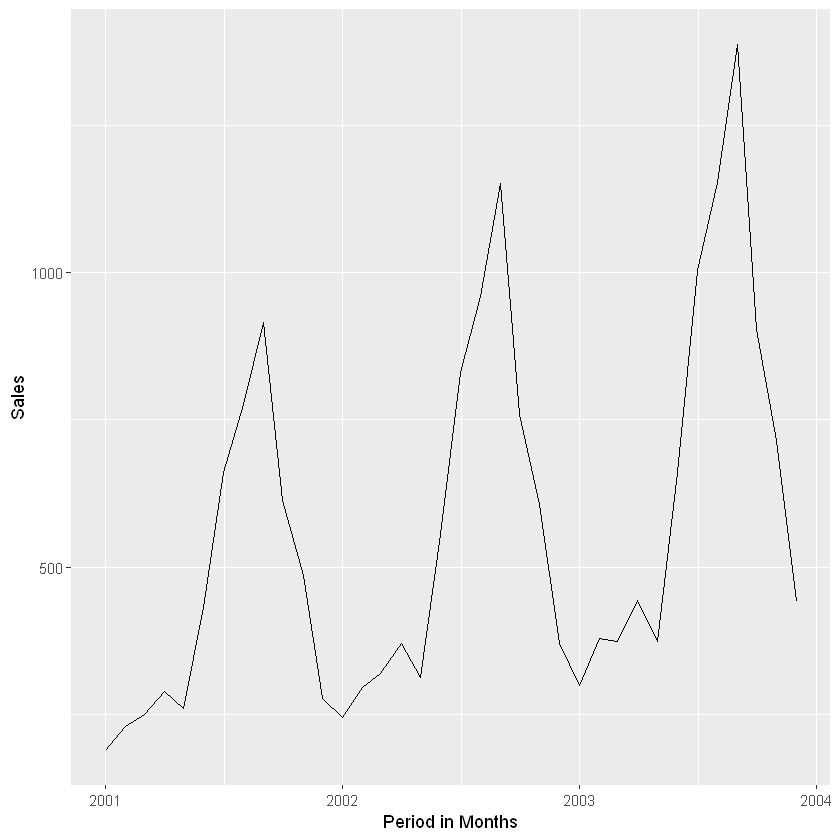

In [2]:
## Time series plots using ggplot
library(zoo)
library(ggplot2)

x1<- as.Date(as.yearmon(time(sales_CSTI))) 
# creates the date variable using as.Date() and as.yearmon()
salesdf <- data.frame(date=x1, Y=as.matrix(sales_CSTI)) # dataframe
salesplot <- ggplot(data=salesdf, mapping=aes(x=date, y=Y)) + geom_line()+xlab("Period in Months") +
  ylab("Sales")
salesplot

### Classical time series decomposition

This example is from Chapter 16, Bruce L. Bowerman, Richard T. O’Connell and Emily S.Murphree, Business Statistics in Practice. 
In classical decomposition approach we assume time series is a combination of Cycle(C), Trend(T), Seasonal(S) and Irregular(I) components. Not all time series have all the components. It is a descriptive model and there are different procedures to decompose the time series. The method used for this example is very simple and illustrative in nature.Interested students are advised read the book mentioned above. The _stats_ package in R also has two functions to do decomposition **decompose()** and **stl()**. See help to understand how these functions decompose the time series before using it. 

There are multiplicative as well additive models. Since the plot of sales indicate a multiplicative model we do a multiplicative decomposition You can apply additive decomposition to multiplicative model by log transforming the series.  

#### Seasonal Index
We use centred moving average to construct the seasonal index

In [4]:
library(forecast) # for the ma() function
sales_CT <- ma(sales_CSTI, order = 12, centre = T) # Centred Moving Average
sales_SI  <- sales_CSTI / sales_CT # Seasonal component and Irreguar term

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [5]:
# codes to estimate the seasonal index:
m_sales = t(matrix(data = sales_SI, nrow = 12))
sales_MM <-  colMeans(m_sales, na.rm = T)# Month averages of seasonality
norm_factor <- rep(12/sum(sales_MM),12)# 
sales_S1 <- sales_MM*norm_factor #Normalised seasonal index
sales_S2 <- rep(sales_S1,3)
sales_S <- ts(sales_S2,start=c(2001,1),frequency=12)

####  Trend component
Trend component is extracted by fitting a trend regression on deseasonalised series. 

In [6]:
trend <- seq(1:36) # time index
# data frame with date, original series and seasonal index
sales_com <- data.frame(x1,sales_CSTI, sales_S)
sales_dS <- sales_CSTI/sales_S # desesonalised data
sales_lm <- lm(sales_dS~trend)
 
sales_T <- predict(sales_lm)  # trend component           
sales_com <- data.frame(sales_com,sales_T) # adding trend to data frame sales_com
                  

#### Cycles
It is difficult to get well defined cycles for a time series as short as this. This stage is discussed here just for the illustrative purpose. 

In [7]:
sales_ST <- sales_S*sales_T #trend and seasonal component
sales_CI <- sales_CSTI/sales_ST # cycle with irregular component
# take 3 month moving average to remove irregular term
sales_C <- ma(sales_CI, order = 3, centre = T) 
sales_com <- data.frame(sales_com,sales_C)

#### Irreguar component
 What is left after removing S,T, and C is the irredular component

In [8]:
sales_I <- sales_CI/sales_C
sales_com <- data.frame(sales_com,sales_I)

Same steps can be followed for an additive model replacing addition for multiplication and subtraction for division.

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."


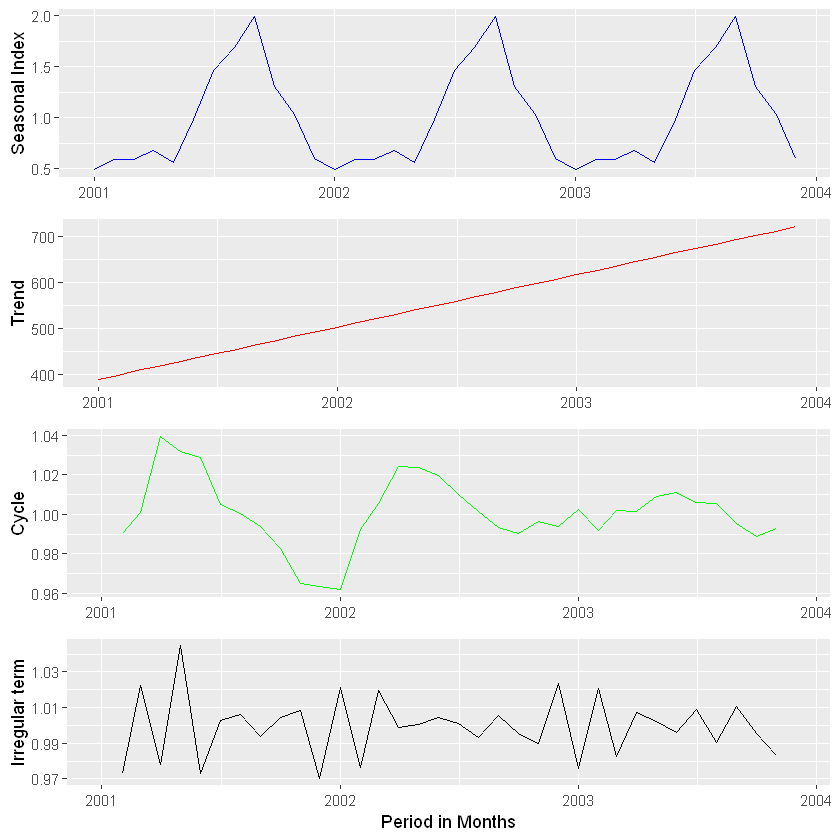

In [15]:
###Plots of all components together

library(gridExtra) # for the function grid.arange
p1<-ggplot(sales_com, mapping=aes(x=x1,y=sales_S))+geom_line(colour="blue")+
                ylab("Seasonal Index")+ xlab(NULL)
p2<-ggplot(sales_com, mapping=aes(x=x1,y=sales_T))+geom_line(color="red")+
                ylab("Trend")+xlab(NULL)
p3<-ggplot(sales_com, mapping=aes(x=x1,y=sales_C))+geom_line(color="green")+
                ylab("Cycle")+xlab(NULL)
p4<-ggplot(sales_com, mapping=aes(x=x1,y=sales_I))+geom_line()+
                ylab("Irregular term")+xlab("Period in Months")
      
 grid.arrange(p1, p2,p3,p4, ncol = 1)

### Home work

- **decompose()** and **stl()** to extract components of sales data  available in ex_deco.csv (Same data we used in the example above). What is the difference between the procedure we used  and the procedures used by these functions.
-  Quarterly data on GDP for India is available in GDP.csv. Create a time series of GDP in R. Find the seasonal index. Generate the plot of GDP and deseasonalised GDP.
